In [1085]:
from abc import ABC
from torch import nn, Tensor, jit, randn, exp, cat, stack
import numpy as np
import torch
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from models.generators import EcgCNNGenerator, ECGLSTMGenerator
from models.discriminators import ECGLSTMDiscriminator
from torchmetrics import AUROC
from sklearn.impute import KNNImputer
import impyute as impy
import seaborn as sns

In [1086]:
from torch.utils.data import ConcatDataset, DataLoader, sampler
from torchvision import transforms, datasets
import patient, ecg_mit_bih, dataset_configs, ecg_dataset_pytorch

In [1087]:
dir(impy)

['__all__',
 '__author__',
 '__build__',
 '__builtins__',
 '__cached__',
 '__copyright__',
 '__doc__',
 '__file__',
 '__license__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__title__',
 '__version__',
 'complete_case',
 'deletion',
 'em',
 'fast_knn',
 'imputation',
 'locf',
 'mean',
 'median',
 'mice',
 'mode',
 'moving_window',
 'random',
 'util']

In [1095]:
class ECGLSTMClassifier(nn.Module):
    def __init__(self, input_dim=216, hidden_dim=512, output_dim=4, num_layers=2):
        super(ECGLSTMClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.layer1 = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=False, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        self.out= nn.Softmax()

    def forward(self, x):
        #s, b, dim

        #print(x.shape)
        x = x.unsqueeze(0)
        #x = x.reshape(64, 72, 3)
        #print ("shape of x ", x.shape)
        #print ("shape of x ", x.shape)

        x, hn = self.layer1(x)
        s, b, h = x.size()
        x = x.reshape(s*b, h)
        #x = x[:, -1, :]
        #print("x shape ", x.shape)
        
        #print ("shape after layer 1 ", x.shape)
        #x = self.mb1(x)
        #print ("shape after mb 1 ", x.shape)
        x = self.linear(x)
        x = self.out(x)
        #exit(0)
        # s, b, outputsize
        #x = x.view(s, b, -1)
        return x


In [1098]:
class ResidualLayer(nn.Module):
    def __init__(self):
        super(ResidualLayer, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, padding=2, bias=True)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, padding=2, bias=True)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)

    def forward(self, x):
        x = self.conv2(F.relu(self.bn1(self.conv1(x)))) + x

        x = F.relu(self.pool1(self.bn2(x)))

        return x


class Net(nn.Module):
    def __init__(self, output_size=4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2, bias=True)
        self.bn1 = nn.BatchNorm1d(32)
        self.res1 = ResidualLayer()
        self.res2 = ResidualLayer()
        self.res3 = ResidualLayer()
        self.res4 = ResidualLayer()
        self.res5 = ResidualLayer()

        self.fc1 = nn.Linear(32 * 3, 32)
        self.fc2 = nn.Linear(32, output_size)
        self.out = nn.Softmax()

    def forward(self, x):
        x = x.view(-1, 1, 216)
        # print(x.shape)
        x = self.conv1(x)

        x = self.bn1(x)
        # print(x.shape)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)

        x = x.view(-1, 32 * 3)

        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = self.out(x)
        return x


In [1115]:
    composed = transforms.Compose([ecg_dataset_pytorch.ToTensor()])
    train_configs_N = dataset_configs.DatasetConfigs('train', one_vs_all=False, lstm_setting=False,
                                        over_sample_minority_class=False,
                                        under_sample_majority_class=False, only_take_heartbeat_of_type='N',
                                        classified_heartbeat='N')
    
    train_configs_S = dataset_configs.DatasetConfigs('train', one_vs_all=False, lstm_setting=False,
                                    over_sample_minority_class=False,
                                    under_sample_majority_class=False, only_take_heartbeat_of_type='S',
                                    classified_heartbeat='S')

    train_configs_V = dataset_configs.DatasetConfigs('train', one_vs_all=False, lstm_setting=False,
                                over_sample_minority_class=False,
                                under_sample_majority_class=False, only_take_heartbeat_of_type='V',
                                classified_heartbeat='V')

    train_configs_F = dataset_configs.DatasetConfigs('train', one_vs_all=False, lstm_setting=False,
                            over_sample_minority_class=False,
                            under_sample_majority_class=False, only_take_heartbeat_of_type='F',
                                classified_heartbeat='F')


    test_configs_N = dataset_configs.DatasetConfigs('test', one_vs_all=False, lstm_setting=False,
                                        over_sample_minority_class=False,
                                        under_sample_majority_class=False, only_take_heartbeat_of_type='N',
                                        classified_heartbeat='N')
    
    test_configs_S = dataset_configs.DatasetConfigs('test', one_vs_all=False, lstm_setting=False,
                                    over_sample_minority_class=False,
                                    under_sample_majority_class=False, only_take_heartbeat_of_type='S',
                                    classified_heartbeat='S')
        
    test_configs_V = dataset_configs.DatasetConfigs('test', one_vs_all=False, lstm_setting=False,
                                over_sample_minority_class=False,
                                under_sample_majority_class=False, only_take_heartbeat_of_type='V',
                                classified_heartbeat='V')

    test_configs_F = dataset_configs.DatasetConfigs('test', one_vs_all=False, lstm_setting=False,
                            over_sample_minority_class=False,
                            under_sample_majority_class=False, only_take_heartbeat_of_type='F',
                            classified_heartbeat='F')
    

    train_data_N = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=train_configs_N)
    train_data_V = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=train_configs_V)
    #train_data_V_copy = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=train_configs_V)
    train_data_S = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=train_configs_S)
    train_data_F = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=train_configs_F)
    
    
    test_data_N = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=test_configs_N)
    test_data_V = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=test_configs_V)
#     test_data_V_copy = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=test_configs_V)
    test_data_S = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=test_configs_S)
    test_data_F = ecg_dataset_pytorch.EcgHearBeatsDatasetPytorch(transform=composed, configs=test_configs_F)


done creating mit bih dataset
training
done creating mit bih dataset
training
done creating mit bih dataset
training
done creating mit bih dataset
training
done creating mit bih dataset
testing
done creating mit bih dataset
testing
done creating mit bih dataset
testing
done creating mit bih dataset
testing


In [95]:
# model_dir = "/Users/alainamahalanabis/Documents/GAN_XAI/src/results/ecg/ECGCNN_Normal/generator.pt"
# #model = ECGLSTMGenerator()
# model = EcgCNNGenerator()
# model.load_state_dict(torch.load(model_dir), strict=False)
# model.eval()

# with torch.no_grad():
#     fake_ecg = model(randn(10000, 100))
#     fake_ecg = fake_ecg.numpy()
#     fake_ecg = np.array(
#         [{'cardiac_cycle': torch.Tensor(x), 'beat_type': 'F',
#           'label': convert_to_one_hot(2)} for x in fake_ecg])

In [1106]:
class ECGLSTMGenerator(nn.Module):
    def __init__(self, input_dim=216, hidden_dim=50, output_dim=216, num_layers=2):
        super(ECGLSTMGenerator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.layer1 = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=True, dropout=0.2)
        self.out = nn.Linear(self.hidden_dim*2, self.output_dim)

    def forward(self, x):
        # s, b, dim
        #print ("SHAPE OF X ", x.shape)
        x = x.float()
        x = x.unsqueeze(0)
        x = x.unsqueeze(0)
        #print ("shape of x ", x.shape)
        x, hn = self.layer1(x)
        #print ("shape of x after layer 1 ", x.shape)
        s, b, h = x.size()
        x = x.view(s*b, h)
        x = self.out(x)
        #x = (torch.sigmoid(x)*2)-0.5
        #print ("shape of x after layer 2 ", x.shape)
        # s, b, outputsize
        #x = x.view(s, b, -1)
        return x


In [97]:
# model_dir = "/Users/alainamahalanabis/Documents/cycleGAN/missing_V_0.5/generator_Z.pt"
# model = ECGLSTMGenerator()
# #model = EcgCNNGenerator()
# model.load_state_dict(torch.load(model_dir), strict=False)
# model.eval()
# missing_ecg = []

# for beat in train_data_V:
#     missing_idx = random.sample(range(216), 86)
#     #print(missing_idx)
#     #print(interpol_fun(np.array(missing_idx)))
#     beat['cardiac_cycle'][missing_idx] = 0
#     missing_ecg.append(model(beat['cardiac_cycle']))


# with torch.no_grad():
#     #fake_ecg = fake_ecg.numpy()
#     missing_ecg = np.array(
#         [{'cardiac_cycle': torch.Tensor(x), 'beat_type': 'V',
#           'label': convert_to_one_hot(1)} for x in missing_ecg])

    
# for beat in missing_ecg:
#     beat['cardiac_cycle'] = beat['cardiac_cycle'].resize(216)
# with torch.no_grad():
# #     #fake_ecg[0] = fake_ecg[0].resize(216)
# #     missing_ecg[0]['cardiac_cycle'] = missing_ecg[8]['cardiac_cycle'].resize(216)
# #     print(missing_ecg[0]['cardiac_cycle'].shape)
#     sns.lineplot(x = range(1,217), y=missing_ecg[0]['cardiac_cycle'])

/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/1991153428.py:29: RuntimeWarning: invalid value encountered in true_divide
  mape_test = np.mean(np.abs((actual - pred) / actual)) * 100
/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/1991153428.py:29: RuntimeWarning: divide by zero encountered in true_divide
  mape_test = np.mean(np.abs((actual - pred) / actual)) * 100


tensor(0.6177, dtype=torch.float64)
mape  99.0039493702464
tensor([-0.1200, -0.1550, -0.1750, -0.2000, -0.2100, -0.2150, -0.2350, -0.2750,
        -0.2700, -0.2750, -0.2600, -0.2600, -0.2700, -0.2900, -0.3350, -0.3600,
        -0.3750, -0.3600, -0.3500, -0.3650, -0.3350, -0.3400, -0.3650, -0.3950,
        -0.4100, -0.3750, -0.3700, -0.3750, -0.3800, -0.3600, -0.3500, -0.3450,
        -0.3500, -0.3650, -0.3650, -0.3400, -0.3300, -0.3150, -0.3150, -0.3350,
        -0.3400, -0.3550, -0.3500, -0.3150, -0.3050, -0.3200, -0.3050, -0.2950,
        -0.2650, -0.2550, -0.2600, -0.2450, -0.2500, -0.2300, -0.1850, -0.1950,
        -0.1700, -0.1350, -0.0800, -0.0150,  0.0400,  0.1000,  0.1300,  0.1850,
         0.2550,  0.3500,  0.5100,  0.6600,  0.7900,  0.9550,  1.1050,  1.1600,
         1.1800,  1.1000,  0.9500,  0.7950,  0.6250,  0.4350,  0.1450, -0.2600,
        -0.7300, -1.0850, -1.2950, -1.3550, -1.3400, -1.2750, -1.2000, -1.1900,
        -1.2100, -1.2250, -1.2400, -1.2650, -1.2800, -1.2750,

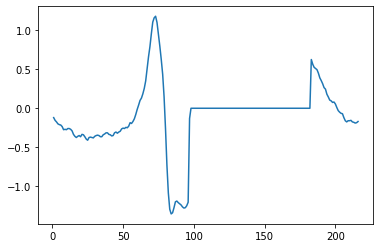

In [864]:
# from scipy.interpolate import UnivariateSpline 
# import random
# import seaborn as sns
# missing_ecg = train_data_V
# one_beat = train_data_V[1]
# x = range(216)
# y=one_beat['cardiac_cycle']
# interpol_fun = UnivariateSpline(x, y)
# interpol_fun
# rmse = 0
# count = 0
# mape = 0
# missing_indices = []

# for i in range(len(train_data_V)):
# #     missing_idx = random.sample(range(216), 43)
#     #print(missing_idx)
#     #print(interpol_fun(np.array(missing_idx)))
#     missing_idx = random.sample(range(129), 1)
#     for idx in missing_idx:
#         for j in range(idx, idx+86):
#             missing_indices.append(j)
#     missing_ecg[i]['cardiac_cycle'][missing_indices] = 0
#     interpol_fun = UnivariateSpline(x, missing_ecg[i]['cardiac_cycle'])
#     missing_ecg[i]['cardiac_cycle'][missing_idx] = torch.tensor(interpol_fun(np.array(missing_idx)))
#     rmse += np.sqrt((train_data_V_copy[i]['cardiac_cycle']-missing_ecg[i]['cardiac_cycle']) ** 2).mean()
#     actual = np.array(train_data_V_copy[i]['cardiac_cycle'])
#     pred = np.array(missing_ecg[i]['cardiac_cycle'])
#     mape_test = np.mean(np.abs((actual - pred) / actual)) * 100
#     if mape_test > 0 and not math.isinf(mape_test):
#         mape += np.mean(np.abs((actual - pred) / actual)) * 100
#         count += 1

# print(rmse/len(train_data_V))
# print("mape ", mape/count)
    
# sns.lineplot(x = range(1,217), y=missing_ecg[0]['cardiac_cycle'])
# print(missing_ecg[0]['cardiac_cycle'])

In [913]:
# import random
# import math

# model_dir = "/Users/alainamahalanabis/Documents/cycleGAN/missing_V_0.5/generator_Z.pt"
# model = ECGLSTMGenerator()
# #model = EcgCNNGenerator()
# model.load_state_dict(torch.load(model_dir), strict=False)
# model.eval()

# X = []
# Y = []

# missing_ecg = []
# with torch.no_grad():
#     for i in range(len(test_data_V)):
#         missing_indices = []
#         original = test_data_V[i]['cardiac_cycle'].float()
#         X.append(test_data_V[i]['cardiac_cycle'].float())
#         Y.append(test_data_V[i]['cardiac_cycle'].float())
#         missing_idx = random.sample(range(107), 1)
#         for idx in missing_idx:
#             for j in range(idx, idx+86):
#                 missing_indices.append(j)
#         #X[i][missing_indices] = np.nan              
#         X[i] = np.array(X[i])
        
# #         Y[i][missing_indices] = 0
#         impute = model(Y[i])
# #         impute = np.interp(impute, (impute.min(), impute.max()), (original.min(), original.max()))
#         X[i][missing_indices] = impute[0,missing_indices]
#         X[i] = X[i].squeeze()
        
# # X = np.array(X)
# # # print(X.shape)
# # X = impy.locf(X)

# with torch.no_grad():
#     for i in range(len(test_data_V)):
# #         missing_ecg.append(X[i,:])
# #         X[i] = X[i].float()
#         missing_ecg.append(X[i])

# with torch.no_grad():
#     #fake_ecg = fake_ecg.numpy()
#     missing_ecg = np.array(
#         [{'cardiac_cycle': torch.Tensor(x), 'beat_type': 'V',
#           'label': convert_to_one_hot(1)} for x in missing_ecg])

# rmse = 0
# mape = 0
# count = 0
# for i in range(len(test_data_V)):
#     rmse += np.sqrt((test_data_V_copy[i]['cardiac_cycle']-missing_ecg[i]['cardiac_cycle']) ** 2).mean()
#     actual = np.array(test_data_V_copy[i]['cardiac_cycle'])
#     pred = np.array(missing_ecg[i]['cardiac_cycle'])
#     mape_test = np.mean(np.abs((actual - pred) / actual)) * 100
#     if mape_test > 0 and not math.isinf(mape_test):
#         mape += np.mean(np.abs((actual - pred) / actual)) * 100
#         count += 1

# print("rmse ", rmse/len(test_data_V))
# print("mape ", mape/count)
    
    
# print(missing_ecg[0]['cardiac_cycle'])
# sns.lineplot(x = range(1,217), y=missing_ecg[0]['cardiac_cycle'])

/Users/alainamahalanabis/.pyenv/versions/3.8.0/envs/GAN_XAI/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alainamahalanabis/.pyenv/versions/3.8.0/envs/GAN_XAI/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/alainamahalanabis/.pyenv/versions/3.8.0/envs/GAN_XAI/lib/python3.8/site-packages/impyute/imputation/cs/fast_knn.py:113: RuntimeWarning: invalid value encountered in true_divide
  weights = distances/np.sum(distances)


IndexError: index 3220 is out of bounds for axis 0 with size 3220

(3220, 216)


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/534423990.py:45: RuntimeWarning: divide by zero encountered in true_divide
  mape_test = np.mean(np.abs((actual - pred) / actual)) * 100
/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/534423990.py:45: RuntimeWarning: invalid value encountered in true_divide
  mape_test = np.mean(np.abs((actual - pred) / actual)) * 100


rmse  tensor(0.0220, dtype=torch.float64)
mape  11.776363870957853
tensor([-0.3300, -0.3300, -0.3300, -0.3300, -0.3050, -0.3050, -0.3000, -0.3000,
        -0.3000, -0.2850, -0.2900, -0.2950, -0.3200, -0.3200, -0.3200, -0.2900,
        -0.3100, -0.3100, -0.3150, -0.3150, -0.2950, -0.2950, -0.3000, -0.3000,
        -0.3000, -0.3200, -0.3200, -0.3200, -0.3200, -0.3100, -0.3200, -0.3250,
        -0.3250, -0.3150, -0.3150, -0.3150, -0.3400, -0.3400, -0.3300, -0.3300,
        -0.3300, -0.3400, -0.3350, -0.3450, -0.3450, -0.3350, -0.3300, -0.3350,
        -0.3350, -0.3350, -0.3650, -0.3650, -0.3800, -0.3850, -0.3850, -0.4400,
        -0.4500, -0.4750, -0.4750, -0.4750, -0.5500, -0.6250, -0.7950, -1.0550,
        -1.3500, -1.3500, -1.9900, -1.9900, -2.3900, -2.5250, -2.6200, -2.6950,
        -2.7150, -2.6900, -2.6250, -2.5350, -2.5350, -2.2600, -2.2600, -1.8050,
        -1.8050, -1.3550, -1.1500, -1.1500, -0.7450, -0.7450, -0.4350, -0.4350,
        -0.2700, -0.2450, -0.2300, -0.2050, -0.1550, 

<AxesSubplot:>

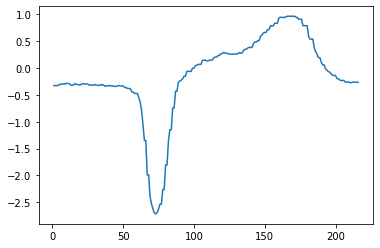

In [1002]:
import random
import math

X = []
Y = []

missing_ecg = []
with torch.no_grad():
    for i in range(len(test_data_V)):
        missing_indices = []
        X.append(test_data_V[i]['cardiac_cycle'])
        missing_indices = random.sample(range(215), 86)
#         for idx in missing_idx:
#             for j in range(idx, idx+108):
#                 missing_indices.append(j)
        X[i][missing_indices] = np.nan 
        #X[i] = X[i].squeeze()
        X[i] = np.array(X[i])
        #X[i] = X[i].squeeze()
        
        
X = np.array(X)
print(X.shape)
X = impy.locf(X)

with torch.no_grad():
    for i in range(len(test_data_V)):
        missing_ecg.append(X[:,i])
#         X[i] = X[i].float()
#         missing_ecg.append(X[i])

with torch.no_grad():
    #fake_ecg = fake_ecg.numpy()
    missing_ecg = np.array(
        [{'cardiac_cycle': torch.Tensor(x), 'beat_type': 'V',
          'label': convert_to_one_hot(1)} for x in missing_ecg])

rmse = 0
mape = 0
count = 0
for i in range(len(test_data_V)):
    rmse += np.sqrt((test_data_V_copy[i]['cardiac_cycle']-missing_ecg[i]['cardiac_cycle']) ** 2).mean()
    actual = np.array(test_data_V_copy[i]['cardiac_cycle'])
    pred = np.array(missing_ecg[i]['cardiac_cycle'])
    mape_test = np.mean(np.abs((actual - pred) / actual)) * 100
    if mape_test > 0 and not math.isinf(mape_test):
        mape += np.mean(np.abs((actual - pred) / actual)) * 100
        count += 1

print("rmse ", rmse/len(test_data_V))
print("mape ", mape/count)
    
    
print(missing_ecg[0]['cardiac_cycle'])
sns.lineplot(x = range(1,217), y=missing_ecg[0]['cardiac_cycle'])

In [387]:
missing_indices = []
missing_idx = random.sample(range(216), 4)
for idx in missing_idx:
    print(idx)
    for i in range(idx, idx+11):
        missing_indices.append(i)
print(missing_indices)

171
214
15
23
[171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [403]:
i

128

In [384]:
for i in range(161, 161+4):
    print(i)
    missing_indices.append(i)
print(missing_indixec)

161
162
163
164


In [189]:
train_data_V_copy[0]['cardiac_cycle']

tensor([-0.1200, -0.1550, -0.1750, -0.2000, -0.2100, -0.2150, -0.2350, -0.2750,
        -0.2700, -0.2750, -0.2600, -0.2600, -0.2700, -0.2900, -0.3350, -0.3600,
        -0.3750, -0.3600, -0.3500, -0.3650, -0.3350, -0.3400, -0.3650, -0.3950,
        -0.4100, -0.3750, -0.3700, -0.3750, -0.3800, -0.3600, -0.3500, -0.3450,
        -0.3500, -0.3650, -0.3650, -0.3400, -0.3300, -0.3150, -0.3150, -0.3350,
        -0.3400, -0.3550, -0.3500, -0.3150, -0.3050, -0.3200, -0.3050, -0.2950,
        -0.2650, -0.2550, -0.2600, -0.2450, -0.2500, -0.2300, -0.1850, -0.1950,
        -0.1700, -0.1350, -0.0800, -0.0150,  0.0400,  0.1000,  0.1300,  0.1850,
         0.2550,  0.3500,  0.5100,  0.6600,  0.7900,  0.9550,  1.1050,  1.1600,
         1.1800,  1.1000,  0.9500,  0.7950,  0.6250,  0.4350,  0.1450, -0.2600,
        -0.7300, -1.0850, -1.2950, -1.3550, -1.3400, -1.2750, -1.2000, -1.1900,
        -1.2100, -1.2250, -1.2400, -1.2650, -1.2800, -1.2750, -1.2500, -1.2050,
        -1.1300, -1.0550, -1.0000, -0.93

<AxesSubplot:>

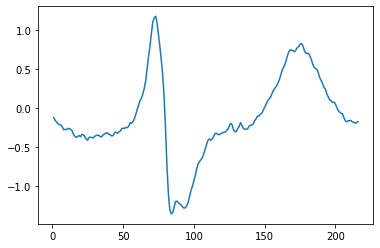

In [727]:
sns.lineplot(x = range(1,217), y=train_data_V_copy[0]['cardiac_cycle'])

In [197]:
a = missing_ecg[0]['cardiac_cycle']
a = a.numpy()
b=train_data_V_copy[0]['cardiac_cycle']
b = b.numpy()
c = np.interp(a, (a.min(), a.max()), (b.min(), +b.max()))

<AxesSubplot:>

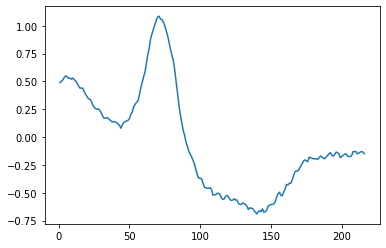

In [517]:
sns.lineplot(x = range(1,217), y=train_data_V_copy[51]['cardiac_cycle'])

In [199]:
np.sqrt((b-c) ** 2).mean()

0.08064692817617342

In [53]:
train_data_V[0]['cardiac_cycle']

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            nan,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [13]:
# from scipy.interpolate import UnivariateSpline 

# import numpy as np 



# x = np.arange(15) 

# y = x**2 + np.sin(x) + 2 



# interpol_fun = UnivariateSpline(x, y) 



# new_arr = interpol_fun(np.arange(3.1, 4, 0.1)) 



# print(new_arr) 

In [527]:
def convert_to_one_hot(label_ind):
    label_one_hot = [0 for _ in range(5)]
    label_one_hot[label_ind] = 1
    return torch.Tensor(label_one_hot)

In [1116]:
model_dir = "/Users/alainamahalanabis/Documents/cycleGAN/saved_images_N_to_F/generator_Z.pt"
model = ECGLSTMGenerator()
#model = EcgCNNGenerator()
model.load_state_dict(torch.load(model_dir), strict=False)
model.eval()

train_F = []

for i in range(len(train_data_N)):
    train_F.append(model(train_data_N[i]['cardiac_cycle']))

with torch.no_grad():
    train_F = np.array(
        [{'cardiac_cycle': torch.Tensor(x), 'beat_type': 'F',
          'label': convert_to_one_hot(2)} for x in train_F])

In [1117]:
model_dir = "/Users/alainamahalanabis/Documents/cycleGAN/saved_images_N_to_S/generator_Z.pt"
model = ECGLSTMGenerator()
#model = EcgCNNGenerator()
model.load_state_dict(torch.load(model_dir), strict=False)
model.eval()

train_S = []

for i in range(len(train_data_N)):
    train_S.append(model(train_data_N[i]['cardiac_cycle']))

with torch.no_grad():
    train_S = np.array(
        [{'cardiac_cycle': torch.Tensor(x), 'beat_type': 'S',
          'label': convert_to_one_hot(0)} for x in train_S])

In [1118]:
model_dir = "/Users/alainamahalanabis/Documents/cycleGAN/saved_images_N_to_V/generator_Z.pt"
model = ECGLSTMGenerator()
#model = EcgCNNGenerator()
model.load_state_dict(torch.load(model_dir), strict=False)
model.eval()

train_V = []

for i in range(len(train_data_N)):
    train_V.append(model(train_data_N[i]['cardiac_cycle']))

with torch.no_grad():
    train_V = np.array(
        [{'cardiac_cycle': torch.Tensor(x), 'beat_type': 'V',
          'label': convert_to_one_hot(1)} for x in train_V])

In [1130]:
for i in range(len(train_S)):
    train_S[i]['cardiac_cycle'] = train_S[i]['cardiac_cycle'].reshape(216)
    
for i in range(len(train_F)):
    train_F[i]['cardiac_cycle'] = train_F[i]['cardiac_cycle'].reshape(216)
    
for i in range(len(train_V)):
    train_V[i]['cardiac_cycle'] = train_V[i]['cardiac_cycle'].reshape(216)

In [1131]:
data = ConcatDataset([train_data_N, train_S, train_F, train_V])

In [1132]:
indices = [i for i in range(int(1 * len(data)))]
loader = DataLoader(data, batch_size=64, sampler=sampler.SubsetRandomSampler(indices), drop_last=True)

In [1133]:
train_S[1]['cardiac_cycle'].shape

torch.Size([216])

In [1141]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [1142]:
for epoch in range(50):  # loop over the dataset multiple times
 
    print("epoch ", epoch)
    running_loss = 0.0
    for i, data in enumerate(loader):
        #print (len(loader))
        #print (i)
        # get the inputs; data is a list of [inputs, labels]
        #print(data.size)
        #print (data)
        inputs = data['cardiac_cycle'].float()
        #inputs = inputs.reshape(64, 72, 3)
        #inputs = torch.cat(inputs)
        #print("inputs shape ", inputs.shape)
   
        labels = data['label']
#         print(labels)
#         print(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print("OUTPUTS SHAPE ", outputs.shape)
        #outputs = outputs.squeeze()
        #print ("output shape ", outputs.shape)
        #outputs = nn.Softmax(outputs)
        loss = criterion(outputs, torch.max(labels,1)[1])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #print ("loss ", loss.item())
        
    print ("epoch ", epoch, "loss, ", loss.item())
            

print('Finished Training')

epoch  0


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


epoch  0 loss,  0.7924392223358154
epoch  1
epoch  1 loss,  0.7523119449615479
epoch  2
epoch  2 loss,  0.7436680197715759
epoch  3
epoch  3 loss,  0.7436679005622864
epoch  4
epoch  4 loss,  0.7436679005622864
epoch  5
epoch  5 loss,  0.7436860203742981
epoch  6
epoch  6 loss,  0.7436685562133789
epoch  7
epoch  7 loss,  0.7436679005622864
epoch  8
epoch  8 loss,  0.7436679005622864
epoch  9
epoch  9 loss,  0.7436679005622864
epoch  10
epoch  10 loss,  0.7436679005622864
epoch  11
epoch  11 loss,  0.7436679005622864
epoch  12
epoch  12 loss,  0.7571007609367371
epoch  13
epoch  13 loss,  0.7436679005622864
epoch  14
epoch  14 loss,  0.7436679005622864
epoch  15
epoch  15 loss,  0.7436679005622864
epoch  16
epoch  16 loss,  0.7436679005622864
epoch  17
epoch  17 loss,  0.7436679005622864
epoch  18
epoch  18 loss,  0.7436679005622864
epoch  19
epoch  19 loss,  0.7436707019805908
epoch  20
epoch  20 loss,  0.7436679005622864
epoch  21
epoch  21 loss,  0.7436679005622864
epoch  22
epoch  

KeyboardInterrupt: 

In [1138]:
testdata = ConcatDataset([test_data_S, test_data_N, test_data_V, test_data_F])
indices = [i for i in range(int(1 * len(testdata)))]
testloader = DataLoader(testdata, batch_size=5400, sampler=sampler.SubsetRandomSampler(indices), drop_last=True)

In [1139]:
len(testloader)

9

In [1140]:
# prepare to count predictions for each class
from sklearn.metrics import roc_auc_score
classes=['S', 'V', 'F', 'N']
correct_pred = {classname: 0 for classname in classes}
print ("correct pred ", correct_pred)
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images = data['cardiac_cycle'].float()
#         print ("images shape ", images.shape)
        labels = data['label']
        labels = torch.max(labels,1)[1]
        outputs = net(images)
        #print(outputs)
        predictions = torch.max(outputs, 1)[1]
        #print ("prections ", len(outputs))
        #print("labels ", labels)
        auc_test = roc_auc_score(labels, outputs, multi_class='ovr')
        print("Auc roc", auc_test)

#         print(len(predictions))
#         print(len(labels))

#         print ("labels ", labels)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == 2:
                print(prediction)
            if label == prediction:
                #print("label ", label)
                #print("pred ", prediction)
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

correct pred  {'S': 0, 'V': 0, 'F': 0, 'N': 0}


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


Auc roc 0.4839561970780286
tensor(3)
tensor(3)
tensor(0)
tensor(3)
tensor(2)
tensor(0)
tensor(2)
tensor(3)
tensor(0)
tensor(3)
tensor(3)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(3)
tensor(0)
tensor(0)
tensor(2)
tensor(2)
tensor(3)
tensor(0)
tensor(2)
tensor(0)
tensor(2)
tensor(3)
tensor(2)
tensor(2)
tensor(3)
tensor(0)
tensor(3)
tensor(3)
tensor(2)
tensor(2)
tensor(3)
tensor(2)
tensor(3)
tensor(2)
tensor(1)
tensor(0)
tensor(2)


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


Auc roc 0.5013125836833635
tensor(1)
tensor(2)
tensor(2)
tensor(3)
tensor(0)
tensor(2)
tensor(3)
tensor(0)
tensor(2)
tensor(3)
tensor(2)
tensor(2)
tensor(0)
tensor(0)
tensor(3)
tensor(3)
tensor(2)
tensor(1)
tensor(3)
tensor(3)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(0)
tensor(2)
tensor(3)
tensor(2)
tensor(0)
tensor(3)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(1)
tensor(3)
tensor(1)
tensor(0)
tensor(0)
tensor(3)
tensor(0)


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


Auc roc 0.4898500477674833
tensor(0)
tensor(0)
tensor(3)
tensor(1)
tensor(3)
tensor(0)
tensor(3)
tensor(3)
tensor(2)
tensor(2)
tensor(3)
tensor(1)
tensor(2)
tensor(1)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(0)
tensor(2)
tensor(2)
tensor(3)
tensor(2)
tensor(1)
tensor(2)
tensor(3)
tensor(3)
tensor(3)
tensor(2)
tensor(3)
tensor(2)
tensor(3)
tensor(3)
tensor(0)
tensor(1)
tensor(2)


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


Auc roc 0.4949206462076317
tensor(2)
tensor(0)
tensor(3)
tensor(3)
tensor(3)
tensor(2)
tensor(2)
tensor(0)
tensor(3)
tensor(1)
tensor(2)
tensor(1)
tensor(3)
tensor(2)
tensor(3)
tensor(2)
tensor(3)
tensor(2)
tensor(2)
tensor(3)
tensor(2)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(2)
tensor(2)
tensor(3)
tensor(0)
tensor(1)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(3)
tensor(2)
tensor(1)
tensor(2)
tensor(1)
tensor(2)


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


Auc roc 0.4795941198162865
tensor(2)
tensor(2)
tensor(0)
tensor(2)
tensor(1)
tensor(0)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(1)
tensor(3)
tensor(3)
tensor(2)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(1)
tensor(1)
tensor(3)
tensor(1)
tensor(0)
tensor(0)
tensor(2)
tensor(2)
tensor(0)
tensor(1)
tensor(0)
tensor(2)
tensor(2)
tensor(0)
tensor(0)
tensor(2)


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


Auc roc 0.4894541585941057
tensor(3)
tensor(3)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(2)
tensor(3)
tensor(2)
tensor(1)
tensor(3)
tensor(1)
tensor(3)
tensor(2)
tensor(1)
tensor(3)
tensor(3)
tensor(3)
tensor(1)
tensor(2)
tensor(1)
tensor(0)
tensor(2)
tensor(1)
tensor(2)
tensor(2)
tensor(2)
tensor(1)
tensor(3)
tensor(3)
tensor(2)
tensor(0)
tensor(3)
tensor(1)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(2)
tensor(3)
tensor(0)
tensor(2)


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


Auc roc 0.4718302086733688
tensor(1)
tensor(3)
tensor(3)
tensor(3)
tensor(0)
tensor(3)
tensor(2)
tensor(3)
tensor(0)
tensor(3)
tensor(3)
tensor(3)
tensor(2)
tensor(2)
tensor(2)
tensor(3)
tensor(0)
tensor(2)
tensor(0)
tensor(3)
tensor(2)
tensor(2)
tensor(0)
tensor(2)
tensor(2)
tensor(1)
tensor(1)
tensor(0)
tensor(2)
tensor(1)
tensor(3)
tensor(0)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(0)
tensor(3)
tensor(3)
tensor(0)


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


Auc roc 0.4690873412886271
tensor(2)
tensor(3)
tensor(1)
tensor(3)
tensor(2)
tensor(1)
tensor(3)
tensor(0)
tensor(3)
tensor(0)
tensor(2)
tensor(0)
tensor(0)
tensor(2)
tensor(1)
tensor(1)
tensor(3)
tensor(3)
tensor(2)
tensor(1)
tensor(1)
tensor(2)
tensor(1)
tensor(3)
tensor(3)
tensor(0)
tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(1)
tensor(3)
tensor(2)
tensor(0)
tensor(3)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(2)
tensor(2)
tensor(3)
tensor(1)
tensor(0)
tensor(2)
tensor(3)
tensor(2)


/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/225895658.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.out(x)


Auc roc 0.47526706064287977
tensor(2)
tensor(0)
tensor(3)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(3)
tensor(3)
tensor(3)
tensor(2)
tensor(1)
tensor(3)
tensor(3)
tensor(3)
tensor(2)
tensor(0)
tensor(0)
tensor(1)
tensor(2)
tensor(3)
tensor(3)
tensor(3)
tensor(2)
tensor(1)
tensor(1)
tensor(0)
tensor(2)
tensor(2)
tensor(1)
tensor(3)
tensor(3)
tensor(0)
tensor(3)
tensor(2)
tensor(3)
tensor(1)
tensor(1)
tensor(2)
tensor(0)
tensor(3)
Accuracy for class: S     is 18.4 %
Accuracy for class: V     is 7.4 %
Accuracy for class: F     is 31.7 %
Accuracy for class: N     is 38.0 %


In [132]:
inputs = [torch.randn(1, 3) for _ in range(5)]

In [39]:
inputs = torch.cat(inputs).view(len(inputs), 1, -1)

In [36]:
inputs = data['cardiac_cycle'].float()
inputs = inputs.reshape(64, 72, 3)

In [42]:
inputs.shape

torch.Size([5, 1, 3])

In [177]:
predictions[0]

tensor([0, 0, 0, 0, 0])

In [203]:
torch.save(net.state_dict(), 'figures/classifier.pt')

In [776]:
model_dir = "/Users/alainamahalanabis/Documents/GAN_XAI/src/results/ecg/ECGCNN_no_wgan/generator.pt"
model = EcgCNNGenerator()
model.load_state_dict(torch.load(model_dir), strict=False)
model.eval()

EcgCNNGenerator(
  (layer1): Sequential(
    (0): ConvTranspose1d(100, 2048, kernel_size=(4,), stride=(1,), bias=False)
    (1): InstanceNorm1d(2048, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose1d(2048, 1024, kernel_size=(4,), stride=(1,), bias=False)
    (1): InstanceNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose1d(1024, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose1d(512, 256, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): 

In [785]:
from matplotlib import pyplot as plt
images = images.detach().numpy()
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12),
              (ax13, ax14, ax15, ax16)) = plt.subplots(4, 4)

ax1.plot(images[0])
ax2.plot(images[1])
ax3.plot(images[2])
ax4.plot(images[3])
ax5.plot(images[4])
ax6.plot(images[5])
ax7.plot(images[6])
ax8.plot(images[7])
ax9.plot(images[8])
ax10.plot(images[9])
ax11.plot(images[10])
ax12.plot(images[11])
ax13.plot(images[12])
ax14.plot(images[13])
ax15.plot(images[14])
ax16.plot(images[15])

for ax in fig.get_axes():
    ax.label_outer()
    #ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth('1')
    ax.axis('on')
    
fig.savefig("/Users/alainamahalanabis/Documents/GAN_XAI/src/results/ecg/ECGCNN_no_wgan/ECGCNN_no_wgan.png")
plt.close()



In [1083]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def SSD(y, y_pred):
    return np.square(y - y_pred).sum()  # axis 1 is the signal dimension


def MAD(y, y_pred):
    return np.abs(y - y_pred).max() # axis 1 is the signal dimension


def PRD(y, y_pred):
    N = np.square(y_pred - y).sum()
    D = np.square(y_pred - y.mean()).sum()

    PRD = np.sqrt(N/D) * 100

    return PRD


def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y)
    y_pred = np.squeeze(y_pred)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

In [1008]:
model_dir = "/Users/alainamahalanabis/Documents/cycleGAN/denoising/generator_Z.pt"
model = ECGLSTMGenerator()
#model = EcgCNNGenerator()
model.load_state_dict(torch.load(model_dir), strict=False)
model.eval()

ECGLSTMGenerator(
  (layer1): LSTM(512, 100, num_layers=2, dropout=0.2, bidirectional=True)
  (out): Linear(in_features=200, out_features=512, bias=True)
)

In [1007]:
class ECGLSTMGenerator(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=100, output_dim=512, num_layers=2):
        super(ECGLSTMGenerator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.layer1 = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=True, dropout=0.2)
        self.out = nn.Linear(self.hidden_dim*2, self.output_dim)


    def forward(self, x):
        # s, b, dim
        #print ("SHAPE OF X ", x.shape)
        x = x.float()
        x = x.unsqueeze(0)
        #print ("shape of x ", x.shape)
        x, hn = self.layer1(x)
        #print ("shape of x after layer 1 ", x.shape)
        s, b, h = x.size()
        x = x.view(s*b, h)
        x = self.out(x)
        #x = (torch.sigmoid(x)*2)-0.5
        #print ("shape of x after layer 2 ", x.shape)
        # s, b, outputsize
        #x = x.view(s, b, -1)
        return x

In [1050]:
with open("/Users/alainamahalanabis/Documents/cycleGAN/x_train.csv") as file_name:
    noise = np.loadtxt(file_name, delimiter=",")

with open("/Users/alainamahalanabis/Documents/cycleGAN/y_train.csv") as file_name:
    denoise = np.loadtxt(file_name, delimiter=",")

In [1054]:
noise = noise[1:7000]
noise = torch.tensor(noise)

In [1055]:
denoise = noise[1:7000]
denoise = torch.tensor(denoise)

/var/folders/nz/gymhhtjx7_3fls3j_3_zgh200000gn/T/ipykernel_24586/2466569996.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  denoise = torch.tensor(denoise)


In [1056]:
denoise_gan = model(noise)

In [1059]:
len(noise)

6996

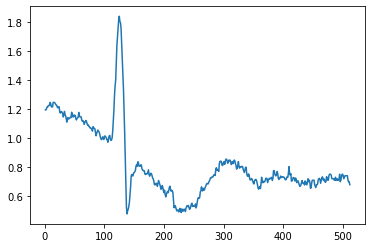

In [1038]:
from matplotlib import pyplot as plt
with torch.no_grad():
    plt.plot(range(1,513), denoise[5], linewidth = 1.5)

In [1069]:
with torch.no_grad():
  tmp = (np.square(denoise[10] - denoise_gan[10])).sum()
print(tmp)

tensor(4459.1232, dtype=torch.float64)


In [1084]:
with torch.no_grad():
    print(COS_SIM(denoise[10], denoise[1]))

[[[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 

In [1074]:
with torch.no_grad():
    SSD(denoise[1], denoise_gan[1])